# 分類

## 分類問題の概要

分類の問題はよく生じるものである。おそらく回帰よりも多いであろう。以下に例を挙げる。

1. 救急処置室に搬送されてきた患者の症状から考えられる原因は3つある。この患者の症状は3つのうちどれが原因であるか。
2. オンライン銀行はユーザーのIPアドレス、過去のこれまでの履歴などによって、いま行われている取引が詐欺であるかどうかを判断しなければならない。
3. ある病気に罹患している人と健康な人の多くのDNA配列データを基にして、生物学者はどのDNA変異がその病気を起こすのか知りたい。

以下では、分類の考え方を``Default``データを使いながら説明する。年収と各月のクレジットカード債務残高をもとにして、顧客がクレジットカードの返済を怠るか否かを予測する。このデータは図4.1に示した。10,000人の顧客について、年収``income``と各月の債務残高``balance``をプロットした。図4.1の左では、ある月の返済を怠った顧客はオレンジで、それ以外の顧客は青で示した。（全体としては債務不履行となる顧客はおよそ3%であるから、返済している顧客についてはその一部しかプロットしていない。）債務不履行になる顧客は、そうでない顧客よりも債務残高が多いように見える。図4.1の右で、2組の箱ひげ図を示す。1つ目は2値変数``default``により``balance``の分布がどのように変化するかを示す。2つ目は同様に``income``の分布を示す。ここでは、``balance``($X_1$)と``income``($X_2$)が与えられたときに、``default``($Y$)を予測するモデルを作る方法を説明する。$Y$は量的変数ではないので、線形回帰モデルを用いることは適切でない。

図4.1を見れば、予測変数``balance``と応答変数``default``の間には明らかに関係があることに気づくが、実際の多くの例では、予測変数と応答変数の間の関係はこれほど強くはない。

In [49]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn.linear_model as skl_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [23]:
df = pd.read_csv('Datasets/Default.csv', index_col=0).dropna()

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


## 図4.1: Defaultデータセット

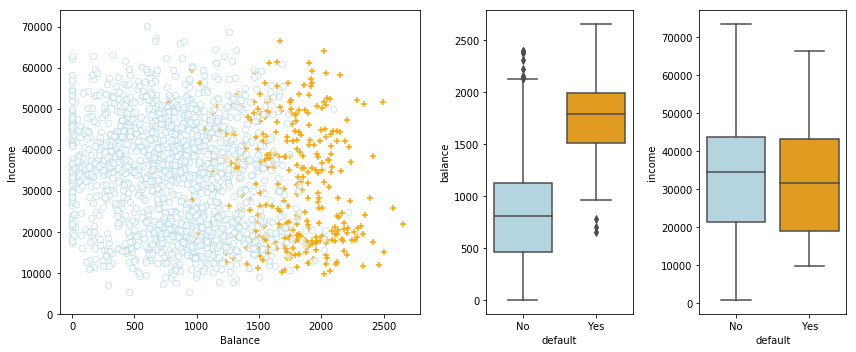

In [24]:
fig = plt.figure(figsize=(12,5))
# 必要なプロットの行数と列数を指定する
gs = mpl.gridspec.GridSpec(1, 4)
# 右端から1つ手前まで
ax1 = plt.subplot(gs[0,:-2])
# 右端から1つ手前
ax2 = plt.subplot(gs[0,-2])
# 右端
ax3 = plt.subplot(gs[0,-1])

# defaultが'no'のサンプルのうち15%を抽出
df_no = df[df.default2 == 0].sample(frac=0.15)
# defaultが'yes'のサンプルをすべて抽出
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(bottom=0)
ax1.set_ylabel('Income')
ax1.set_xlim(left=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

## なぜ線形回帰を用いないのか

冒頭において、質的な応答変数の場合は線形回帰は適切ではないと論じた。これはなぜであろうか。

救急治療室に運び込まれた患者の症状から、病名を予測したいとする。例を単純にするため、患者は脳卒中、薬物過剰摂取、てんかん性発作のうちのいずれかであるとする。これらを量的な応答変数
\begin{equation}
    Y = \begin{cases}
        1 & \text{脳卒中の場合} \\
        2 & \text{薬物過剰摂取の場合} \\
        3 & \text{てんかん性発作の場合} 
    \end{cases}
\end{equation}
へコード化することを考える。このコード化を使い、最小2乗法によって線形回帰をあてはめ、予測変数$X_1, \ldots, X_p$に対応する応答変数$Y$を予測できそうなものである。
残念ながら、上のコード化によると、薬物過剰摂取は脳卒中とてんかん性発作の間にあることになるし、脳卒中と薬物過剰摂取の違いは薬物過剰摂取とてんかん性発作の違いと同じということになる。実際にはこのようにすべき理由はない。例えば、以下のコード化
\begin{equation}
    Y = \begin{cases}
        1 & \text{てんかん性発作の場合} \\
        2 & \text{脳卒中の場合} \\
        3 & \text{薬物過剰摂取の場合} 
    \end{cases}
\end{equation}
も同様に合理的である。しかしこれは3つの病状について全く異なる関係を示すことになる。これらの異なるコード化を使えば、根本的に異なる線形モデルとなり、テストデータにおいて全く異なる予測をすることになる。

もしも応答変数のとりうる値が、例えばmild(症状が軽い), moderate(中程度), severe(重い)などのように自然な順序がある場合、かつmildとmoderateの違いがmoderateとsevereの違いと似たようなものだと言えるならば、1, 2, 3と割り当てるのは理にかなっているといえる。しかし残念ながら、一般的には3クラス以上ある質的変数を量的変数に変換して線形回帰が機能するような方法はない。

量的な2値変数であれば、まだ対処のしようがある。例えば、患者の病状が脳卒中と薬物過剰摂取のどちらかであるとする。このとき、ダミー変数を使って
\begin{equation}
    Y = \begin{cases}
        0 & \text{脳卒中の場合} \\
        1 & \text{薬物過剰摂取の場合} 
    \end{cases}
\end{equation}
のように応答変数をコード化することができる。そしてこの2値応答変数を使って線形回帰をあてはめ、$\hat{Y} > 0.5$であれば薬物過剰摂取、その他の場合は脳卒中であると予測することになる。2値変数の場合、上記を逆に割り当てたとしても、線形回帰がまったく同じ予測をすることは容易に示される。

2値の応答変数に0/1を上のように割り当てた場合、最小2乗法による回帰を使うことは道理にかなっている。線形回帰で得られる$X\hat{\beta}$がこの場合においては$\mathrm{Pr}(\text{薬物過剰摂取}|X)$の推定値となるのである。しかし線形回帰を行った場合、推定値が区間$[0, 1]$から外れる場合があり、これでは確率とは言えなくなってしまう。それでも、この予測値は順序づけのために用いることができ、確率の大雑把な推定値として使うことができる。

しかし、ダミー変数を用いたアプローチは3つ以上のカテゴリーをある質的変数の場合には簡単に拡張することができない。これらの理由により、質的変数を扱うのにより適した分類の方法を使うことが望ましい。

## ロジスティック回帰 

``Default``データにおいて、応答変数である``default``の値は2つのカテゴリー``Yes``または``No``のどちらかであった。応答変数$Y$を直接モデル化するのではなく、ロジスティック回帰においては、$Y$が特定のカテゴリーに属する確率をモデル化する。

``Default``データにおいては、ロジスティック回帰は債務不履行の確率をモデル化する。例えば、ある債務残高``balance``において債務不履行になる確率は
\begin{equation}
    \mathrm{Pr}(\mathrm{default} = \mathrm{Yes}|\mathrm{balance})
\end{equation}
と書ける。

$\mathrm{Pr}(\mathrm{default} = \mathrm{Yes}|\mathrm{balance})$を簡単に$p(\mathrm{balance})$と書く。この値は0と1の間の数値である。``balance``の値が与えられれば、``default``の予測を行うことができる。例えば、$p(\mathrm{balance}) > 0.5$のとき、$\mathrm{default} = \mathrm{Yes}$と予測できるかもしれない。または、顧客の債務不履行のリスクについてより保守的な会社であれば、例えば$p(\mathrm{balance}) > 0.1$のようにより低い境界値を使うかもしれない。

### ロジスティックモデル

$p(X) = \mathrm{Pr}(Y=1|X)$と$X$の間の関係をどのようにすればモデル化することができるであろうか。（便宜上、応答変数には一般的な0/1を割り当てることとする）。先に論じたように線形回帰モデルを使うことを考えると次のようになる：

\begin{equation}
    p(X) = \beta_0 + \beta_1 X \tag{4.1}
\end{equation}

このアプローチにより``balance``を使って``default=Yes``を予測した場合、図4.2の左に示されたモデルが得られる。この方法には問題があることがわかる。まず債務残高が$0$に近いと、債務不履行の確率が負の値になってしまう。また、債務残高がとても大きいと、確率が$1$よりも大きくなってしまう。これらはもちろん道理に合わない。債務不履行の確率は、クレジットカード債務残高に関わらず、$0$と$1$の間でなければならないはずである。このような問題が起きるのは、クレジットカード債務のデータだけに限らない。$0$と$1$を割り当てた2値応答変数に直線を当てはめた場合、原理的には（$X$の範囲を限定しなければ）ある$X$の値については$p(X) < 0$となり、またある$X$については$p(X) > 1$となる。

この問題を避けるため、$p(X)$はすべての$X$について$0$と$1$の間となるような関数を使わなければならない。この条件を満たす関数は多くある。ロジスティック回帰においては、ロジスティック関数
\begin{equation}
    p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}} \tag{4.2}
\end{equation}
を使う。

モデル(4.2)を当てはめるのに、最尤推定法を用いる。図4.2の右は、``Default``データにロジスティック回帰モデルを当てはめた結果である。債務残高が少ない場合、債務不履行の確率は$0$に近いが、負の値にはなっていない。また債務残高が多い場合を見ると、債務不履行の確率は大きいが、$1$より大きくはなっていない。

式(4.2)を少し変形することにより
\begin{equation}
    \frac{p(X)}{1 - p(X)} = e^{\beta_0 + \beta_1 X} \tag{4.3}
\end{equation}

を得る。これはオッズと呼ばれ、$0$と$\infty$の間のどの値もとりうる。オッズが$0$や$\infty$に近いということは債務不履行の確率がそれぞれ低い、または高いことを示している。

式(4.3)の両辺の対数をとることにより、
\begin{equation}
    \log \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 X \tag{4.4}
\end{equation}

を得る。左辺は対数オッズまたはロジットと呼ばれる。ロジスティック回帰モデル(4.2)は、$X$について線形なロジットをもつことがわかる。

線形回帰モデルにおける$\beta_1$は、$X$を1単位増加させたときの$Y$の平均変化量である。それに対して、ロジスティック回帰モデルにおいては、$X$を1単位増加させると、対数オッズを$\beta_1$だけ増加させる（式(4.4)）。あるいはオッズを$e^{\beta_1}$倍にする（式(4.3)）。しかし、式(4.2)において$X$と$p(X)$の関係は線形ではないため、$\beta_1$は$X$を1単位増加させたときの$p(X)$の変化に対応していない。$X$を1単位増加させたときの$p(X)$の変化量は$X$の値に依存する。しかし$X$の値に関わらず、$\beta_1$が正であれば、$X$を増加させたときに$p(X)$も増加する。図4.2の右を見ると、$X$と$p(X)$の関係は直線ではないこと、また$X$を1単位変化させたときの$p(X)$の変化率は$X$に依存していることが確認できる。

### 図4.2 

array([[0.000e+00],
       [1.000e+00],
       [2.000e+00],
       ...,
       [2.652e+03],
       [2.653e+03],
       [2.654e+03]])

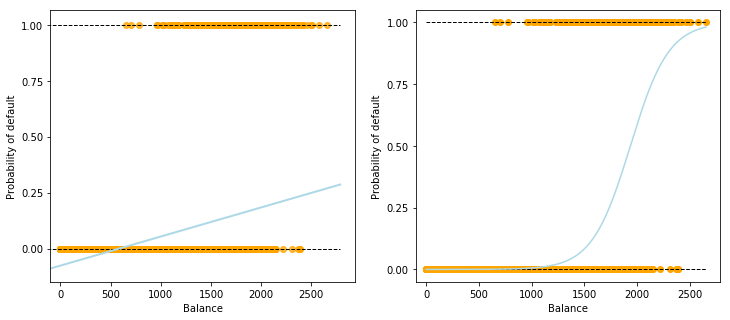

In [41]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

# solver='newton-cg'にすると収束しない
clf = skl_lm.LogisticRegression(solver='lbfgs')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# 左プロット
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# 右プロット
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(left=-100)

### 回帰係数の推定

式(4.2)の係数$\beta_0$と$\beta_1$は未知であり、訓練データを使って推定しなければならない。線形回帰モデルでは、未知の回帰係数を推定するのに最小2乗法を使った。モデル(4.4)を当てはめるのに（非線形）最小2乗法を使うことも考えられるが、より一般的な最尤法の方が好ましい。なぜなら、最尤推定の方が統計的によりよい特性をもっているからである。直観的には、以下のように最尤推定を使ってロジスティック回帰を当てはめる：式(4.2)を使って予測したそれぞれの顧客の債務不履行の確率$\hat{p}(x_i)$が、その顧客の返済状況にできるだけ近い値になるように$\beta_0$と$\beta_1$を推定する。つまり、式(4.2)に代入して$p(X)$を計算した結果が、債務不履行の顧客については$1$に近い数値に、また債務不履行でない顧客については$0$に近い数値になるよう、$\hat{\beta}_0$と$\hat{\beta}_1$を選びたいのである。この考え方は、以下の尤度関数によって定式化される：
\begin{equation}
    l(\beta_0, \beta_1) = \prod_{i:y_i=1}p(x_i) \prod_{i':y_{i'}=0} (1 - p(x_{i'})) \tag{4.5}
\end{equation}
この尤度関数を最大化するような$\hat{\beta}_0$と$\hat{\beta}_1$を選ぶ。

表4.1は``Default``データにおいて、``balance``から``default=Yes``となる確率を予測するロジスティック回帰の結果をまとめたものである。$\hat{\beta}_1 = 0.0055$であり、``balance``が増加すると``default``の確率も増加することがわかる。正確には、``balance``が1単位増加したとき、``default``のロジットは$0.0055$増加する。

表4.1におけるロジスティック回帰の結果の多くは、線形回帰の結果と類似している。例えば、標準誤差を計算することによって回帰係数の推定値の正確さを計測することができる。例えば、$\beta_1$のz統計量は$\hat{\beta}_1/\mathrm{SE}(\hat{\beta}_1)$であり、絶対値が大きなz統計量は帰無仮説$H_0: \beta_1 = 0$を棄却する根拠となる。この帰無仮説は$p(X) = \frac{e^{\beta_0}}{1 + e^{\beta_0}}$、つまり``default``の確率は``balance``に依存しないとする。表4.1で``balance``のp値は小さいので、$H_0$を棄却することができる。つまり``balance``と``default``の確率の間には関係があるということになる。表4.1の切片には通常それほど関心が持たれることはない。切片の役割は、確率の平均を全データのうちクラスが1のデータの割合に合わせることである。

### ロジスティック回帰における予測

回帰係数が推定されたならば、後はクレジットカードの債務残高に対して``default``の確率を計算するのみである。例えば、表4.1の係数の推定値を使うと、``balance``が$1,000である顧客については、債務不履行の確率は1\%以下であると予測される：

\begin{equation}
    \hat{p}(X) = \frac{e^{\hat{\beta}_0 + \hat{\beta}_1 X}}{1 + e^{\hat{\beta}_0 + \hat{\beta}_1 X}} = \frac{e^{-10.6513 + 0.0055 \times 1000}}{1 + e^{-10.6513 + 0.0055 \times 1000}} = 0.00576
\end{equation}

これに対し、債務残高が$2,000の顧客が債務不履行に陥る確率はさらに高く、0.586つまり58.6\%であると予測される。

ロジスティック回帰モデルでも、ダミー変数を使うことにより、質的な予測変数を使うことができる。例えば、``Default``データセットには``student``という質的変数がある。モデルを当てはめるには、学生には1を、学生以外には0となるダミー変数を作成すればよい。学生であるか否かにより、債務不履行の確率を予測するロジスティック回帰の結果を表4.2に示す。ダミー変数の係数は正であり、p値は統計的に有意である。これは学生の方が学生でない人よりも、債務不履行の確率が高いことを表している：

\begin{align}
    \hat{\mathrm{Pr}}(\mathrm{default} = \mathrm{Yes}|\mathrm{student} = \mathrm{Yes}) = \frac{e^{-3.5041+0.4049 \times 1}}{1 + e^{-3.5041+0.4049 \times 1}} = 0.0431 \\
    \hat{\mathrm{Pr}}(\mathrm{default} = \mathrm{Yes}|\mathrm{student} = \mathrm{No}) = \frac{e^{-3.5041+0.4049 \times 0}}{1 + e^{-3.5041+0.4049 \times 0}} = 0.0292
\end{align}

### 多重ロジスティック回帰

複数の予測変数を使って2値の応答変数を予測する。式(4.4)を以下のように拡張する：

\begin{equation}
    \log \left( \frac{p(X)}{1 - p(X)}\right) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p \tag{4.6}
\end{equation}

ここに、$X = (X_1, \ldots, X_p)$は$p$個の予測変数である。式(4.6)から以下を得る：

\begin{equation}
    p(X) = \frac{e^{\beta_0 + \beta_1 X_1 + \cdots \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \cdots \beta_p X_p}} \tag{4.7}
\end{equation}

$\beta_0, \beta_1, \ldots, \beta_p$の推定には最尤法を用いる。

表4.3に``balance``、``income``（単位：千ドル）そして学生か否かを表す``student``を使い、``default``の確率を予測する多重ロジスティック回帰モデルの係数を示す。

ここで得られた結果は驚くべきものである。``balance``と``student``を表すダミー変数についてのp値はとても小さい。つまりこれらの変数は``default``の確率に関係している。しかし、ダミー変数の係数は負である。これは学生の顧客の方が学生でない顧客よりも債務不履行になりにくいということである。それに対して、表4.2ではダミー変数の係数は正であった。表4.2では顧客が学生であると債務不履行の確率が増加するのに、表4.3では減少するというのはどういうことであろうか。図4.3の左で、この一見矛盾しているような現象を理解することができる。学生の顧客と学生でない顧客の債務不履行の確率をクレジットカード債務残高の関数として、オレンジと青の線でそれぞれ示す。多重ロジスティック回帰モデルにおいて``student``の係数が負であるということは、``balance``と``income``の値を固定したときに、学生の顧客の方が学生でない顧客よりも債務不履行になりにくいことを表している。確かに、図4.3の左を見ると、``balance``の値に関わらず、学生の顧客の方が、学生でない顧客よりも債務不履行の確率は低いことがわかる。一方、プロットの横軸近くにある水平の破線はすべての``balance``と``income``の値での学生と学生でない顧客の債務不履行の平均確率を表し、ここでは逆の現象が見られる。つまり全体としては、学生の学生の債務不履行の確率の方が、学生でない顧客よりも高いのである。結果として、表4.2のロジスティック回帰での変数``student``の係数は正になっている。

図4.3の右がこの矛盾を説明している。変数``student``と``balance``には相関がみられる。学生のクレジットカード債務残高は高くなる傾向があり、その高い債務残高によって債務不履行の確率が高くなっている。つまり、図4.3の左からわかるように学生はクレジットカードの債務残高が大きく、そのため債務不履行の可能性も高いのである。したがって、クレジットカードの債務残高が同じであれば、学生の方が学生でない顧客よりも債務不履行の確率は低いものの、全体としては学生の学生の方が学生でない顧客よりもクレジットカードの債務残高が高くなる傾向にあるため、学生の方が学生でない顧客よりも高い確率で債務不履行に陥るのである。これは与信管理の観点からクレジットカード会社によってとても重要な点である。クレジットカード債務残高についての情報がない場合、学生は学生でない顧客よりもリスクが高いが、クレジットカードの債務残高が同じであれば、学生の方が学生でない顧客よりもリスクが低い。

この単純な例により、他の予測変数が関係があるのに、単一の変数のみを使って回帰を当てはめることの危険性と難しさがわかる。線形回帰の場合と同様、1つだけの予測変数を得られた結果は、複数の変数を使った場合の結果とまったく異なることもありうる。特に予測変数同士に相関がある場合はこのような現象が起こる。一般に、図4.3に見られる現象を交絡と呼ぶ。

### 表4.1

#### scikit-learn

In [58]:
y = df.default2
clf = skl_lm.LogisticRegression(solver='lbfgs')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132824]


#### statsmodels 

In [59]:
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


### 表4.2

In [60]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


### 表4.3

In [61]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


### 図4.3

In [65]:
# studentsのbalance(X)とdefault(Y)を抽出
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# non-studentsのbalance(X)とdefault(Y)を抽出
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# プロットのためのbalanceのベクトル
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [67]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


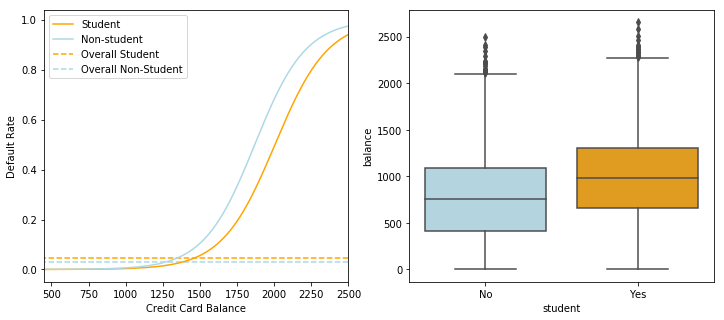

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# 左プロット
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
# groupbyの結果から破線を引く
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# 右プロット
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);